## Extract images

In [3]:
import os
import numpy as np
import cv2

data_dir = './weather'

def load_images(classes) -> (np.ndarray, np.ndarray):
    print("[INFO] Loading images...")
    images = []
    labels = []
    
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            try:
                img = cv2.imread(image_path)
                img = cv2.resize(img, (150, 150))  # Resize, images have different sizes in the dataset
                images.append(img)
                labels.append(class_name)  # Assign label
            except Exception as e:
                print(f"Error loading image: {image_path}. Error: {e}")
    
    # Convert lists to numpy arrays for further processing and normalize
    images = np.array(images)/255.0
    labels = np.array(labels)
    
    # Print the shapes to verify
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    
    print(f"[INFO] Loaded {images.shape[0]} images.")
    
    return images, labels

## Show sample images

In [4]:
import matplotlib.pyplot as plt
import random

def show_sample_images(images, labels: np.ndarray):
    print("[INFO] Plotting sample images...")
    plt.figure(figsize=(12, 10))
    for i in range(9):
        n = random.randrange(len(images))
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[n])
        plt.title(labels[n])
        plt.axis("off")

## Data preparation

In [33]:
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder


# Perform one-hot encoding for the labels convert to one-valued arr
def onehot_encode_1bit(labels, images: np.ndarray) -> np.ndarray:
    print("[INFO] Performing one-hot encoding on 1 node...")
    # Version 1 -> (Single Binary Digit)
    encoder = LabelBinarizer()
    labels_onehot = encoder.fit_transform(labels)
    labels_onehot = labels_onehot.astype(float) # convert to float
    
    print("Images shape:", images.shape)
    print("Labels encoded using LabelBinarizer(), labels.shape:", labels_onehot.shape)
    
    return labels_onehot

# Perform one-hot encoding for the labels convert to one-valued arr
def onehot_encode_2bit(labels, images: np.ndarray) -> (np.ndarray, dict):
    print("[INFO] Performing one-hot encoding on multiple nodes...")
    # Version 2 -> n nodes
    encoder = OneHotEncoder()
    labels = np.array(labels).reshape(-1, 1)
    labels_onehot = encoder.fit_transform(labels)
    labels_onehot = labels_onehot.astype(float) # convert to float
    labels_onehot = labels_onehot.toarray()
    
    # Display the mapping between original classes and one-hot encoded columns
    original_classes = encoder.categories_[0]
    mapping = {col_idx: class_label for col_idx, class_label in enumerate(original_classes)}
    print("Mapping between column indices and original classes:")
    print(mapping)
    
    print("Images shape:", images.shape)
    print("Labels encoded using OneHotEncoder(), labels.shape:", labels_onehot.shape)
    
    return labels_onehot, mapping

## Model evaluation

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

def evaluate_model(H, y_pred, y_test):
    print("[INFO] Evaluating model...")

    print(f'Type and shape of y_test: {type(y_test)} | {y_test.shape}')
    print(f'Type and shape of y_pred: {type(y_pred)} | {y_pred.shape}')

    print('Model\'s predictions:')
    print(y_pred)
    
    print('\nConfusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred)*100:.1f}%")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.1f}%")
    
    # plot the training loss and accuracy
    N = 10 # epoch number
    plt.style.use("ggplot")
    plt.figure(figsize=(14,8))
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()

# Exercise 1.1 - 2 classes, class labels to binary encoded labels (1D array)

In [51]:
images, labels = load_images(['cloudy', 'sunrise'])

[INFO] Loading images...
Images shape: (657, 150, 150, 3)
Labels shape: (657,)
[INFO] Loaded 657 images.


[INFO] Plotting sample images...


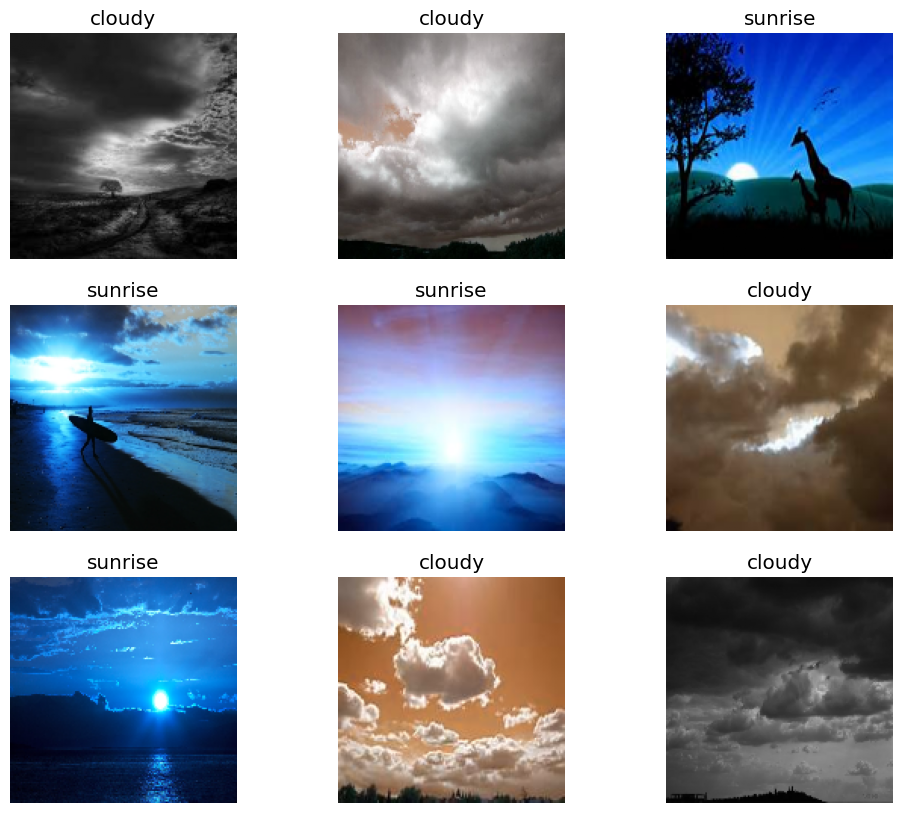

In [52]:
show_sample_images(images, labels)

In [53]:
labels_onehot = onehot_encode_1bit(labels, images)

[INFO] Performing one-hot encoding on 1 node...
Images shape: (657, 150, 150, 3)
Labels encoded using LabelBinarizer(), labels.shape: (657, 1)


## Split train and test data

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels_onehot, test_size=0.25, random_state=12)

print(f'Shape of the training set: {X_train.shape}')
print(f'Shape of the test set: {X_test.shape}')
print(f'Balance of training set: class \'1\': {np.count_nonzero(y_train == 1)/y_train.shape[0]*100:.1f}% of total samples')

Shape of the training set: (492, 150, 150, 3)
Shape of the test set: (165, 150, 150, 3)
Balance of training set: class '1': 51.6% of total samples


## Build CNN model

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

img_width, img_height, color_channel = X_train.shape[1:4]

classes = 1

# Build the CNN model
model = Sequential([
    # This layer extracts 64 different 3x3 features
    # Typically you’ll see strides of 2×2 as a replacement to max pooling:
    Conv2D(64, (3, 3), input_shape=(img_width, img_height, color_channel), padding="same", activation='relu'),
    Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation='relu'),
    Dropout(0.25), # Dropout helps generalize and not overfit. Neurons from the current layer, with probability p, will randomly disconnect from neurons in the next layer so that the network has to rely on the existing connections.

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    Dropout(0.25),

    Flatten(),
    # Use ReLU to avoid vanishing gradients problem
    Dense(512, activation='relu'),
    
    Dense(classes, activation='sigmoid'), # Binary Classification: One node, sigmoid activation.
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 dropout_2 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 38, 128)       147584    
                                                                 
 dropout_3 (Dropout)         (None, 38, 38, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 184832)           

## Train and fit

In [56]:
# Consider using 'binary_crossentropy' if you only have 2 classes.
# In other cases (more classes use 'categorical_crossentropy')
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

H = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test)) 

Epoch 1/10


2023-11-18 12:23:04.224532: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 2s 45ms/step - loss: 1.0131 - accuracy: 0.7033 - val_loss: 0.2999 - val_accuracy: 0.8970
Epoch 2/10
16/16 [==============================] - 1s 36ms/step - loss: 0.1884 - accuracy: 0.9512 - val_loss: 0.1259 - val_accuracy: 0.9636
Epoch 3/10
16/16 [==============================] - 1s 36ms/step - loss: 0.0711 - accuracy: 0.9837 - val_loss: 0.1568 - val_accuracy: 0.9697
Epoch 4/10
16/16 [==============================] - 1s 37ms/step - loss: 0.0449 - accuracy: 0.9837 - val_loss: 0.1447 - val_accuracy: 0.9697
Epoch 5/10
16/16 [==============================] - 1s 37ms/step - loss: 0.0311 - accuracy: 0.9878 - val_loss: 0.1233 - val_accuracy: 0.9697
Epoch 6/10
16/16 [==============================] - 1s 36ms/step - loss: 0.0308 - accuracy: 0.9878 - val_loss: 0.1038 - val_accuracy: 0.9636
Epoch 7/10
16/16 [==============================] - 1s 36ms/step - loss: 0.0255 - accuracy: 0.9898 - val_loss: 0.1491 - val_accuracy: 0.9636
Epoch 8/10
16/16 [======

## Model evaluation

6/6 [==============================] - 0s 42ms/step
[INFO] Evaluating model...
Type and shape of y_test: <class 'numpy.ndarray'> | (165, 1)
Type and shape of y_pred: <class 'numpy.ndarray'> | (165,)
Model's predictions:
[1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1
 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0
 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1]

Confusion matrix:
[[62  0]
 [ 5 98]]
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        62
         1.0       1.00      0.95      0.98       103

    accuracy                           0.97       165
   macro avg       0.96      0.98      0.97       165
weighted avg       0.97      0.97      0.97       165

Cohen's Kappa: 93.6%
Accuracy: 97.0%


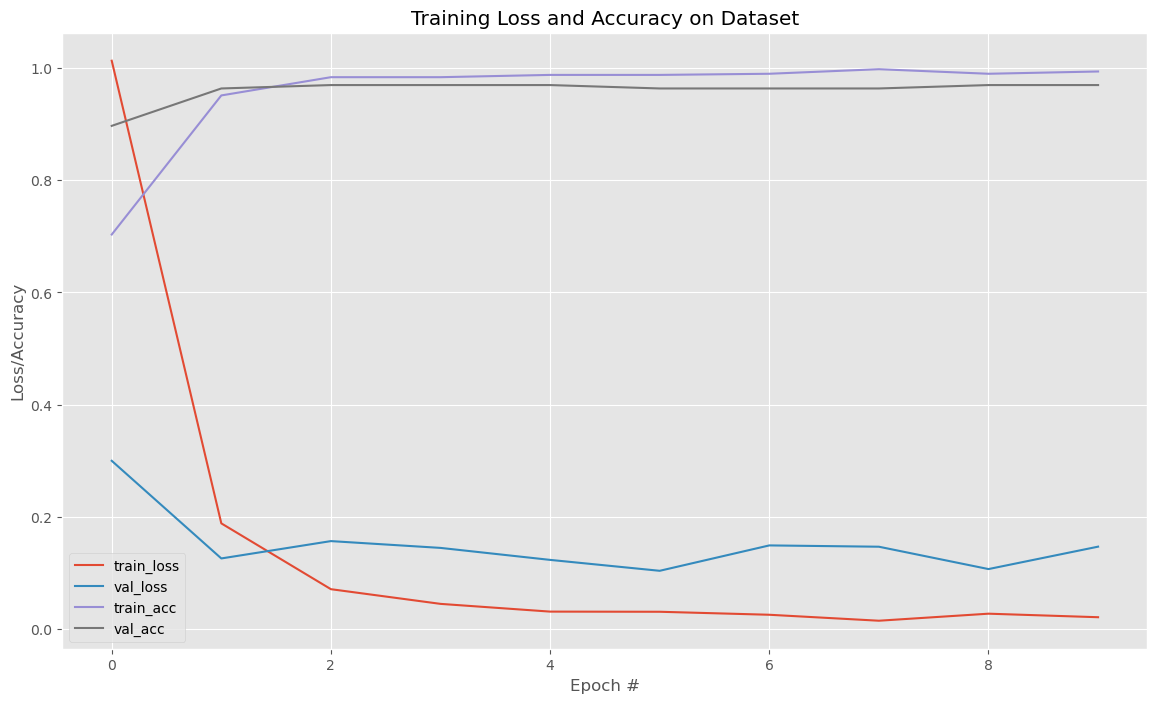

In [58]:
y_pred = model.predict(X_test)
y_pred = [1 if x > 0.5 else 0 for x in y_pred] # sigmoid - need to round predicted
y_pred = np.array(y_pred)

evaluate_model(H, y_pred, y_test)

# Exercise 1.2 - 2 classes, class labels to binary encoded labels (2D array)

In [59]:
images, labels = load_images(['cloudy', 'sunrise'])

[INFO] Loading images...
Images shape: (657, 150, 150, 3)
Labels shape: (657,)
[INFO] Loaded 657 images.


In [60]:
labels_onehot, _ = onehot_encode_2bit(labels, images)

[INFO] Performing one-hot encoding on 2 nodes...
Images shape: (657, 150, 150, 3)
Labels encoded using OneHotEncoder(), labels.shape: (657, 2)


In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels_onehot, test_size=0.25, random_state=12)

print(f'Shape of the training set, X: {X_train.shape}, y: {y_train.shape}')
print(f'Shape of the test set: {X_test.shape}, y: {y_test.shape}')

Shape of the training set, X: (492, 150, 150, 3), y: (492, 2)
Shape of the test set: (165, 150, 150, 3), y: (165, 2)


## Build CNN model

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

img_width, img_height, color_channel = X_train.shape[1:4]

classes = 2

# Build the CNN model
model = Sequential([
    # This layer extracts 64 different 3x3 features
    # Typically you’ll see strides of 2×2 as a replacement to max pooling:
    Conv2D(64, (3, 3), input_shape=(img_width, img_height, color_channel), padding="same", activation='relu'),
    Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation='relu'),
    Dropout(0.25), # Dropout helps generalize and not overfit. Neurons from the current layer, with probability p, will randomly disconnect from neurons in the next layer so that the network has to rely on the existing connections.

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    Dropout(0.25),

    Flatten(),
    # Use ReLU to avoid vanishing gradients problem
    Dense(512, activation='relu'),
    
    Dense(classes, activation='softmax'), # Multiclass Classification: One node per class, softmax/sigmoid activation.
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 38, 38, 128)       147584    
                                                                 
 dropout_5 (Dropout)         (None, 38, 38, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 184832)           

In [63]:
# Consider using 'binary_crossentropy' if you only have 2 classes.
# In other cases (more classes use 'categorical_crossentropy')
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

H = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test)) 

Epoch 1/10
16/16 [==============================] - 2s 56ms/step - loss: 1.5752 - accuracy: 0.7785 - val_loss: 0.1923 - val_accuracy: 0.9273
Epoch 2/10
16/16 [==============================] - 1s 36ms/step - loss: 0.1477 - accuracy: 0.9797 - val_loss: 0.2881 - val_accuracy: 0.9273
Epoch 3/10
16/16 [==============================] - 1s 36ms/step - loss: 0.0929 - accuracy: 0.9797 - val_loss: 0.1736 - val_accuracy: 0.9697
Epoch 4/10
16/16 [==============================] - 1s 37ms/step - loss: 0.0396 - accuracy: 0.9878 - val_loss: 0.1739 - val_accuracy: 0.9697
Epoch 5/10
16/16 [==============================] - 1s 37ms/step - loss: 0.0264 - accuracy: 0.9898 - val_loss: 0.0935 - val_accuracy: 0.9697
Epoch 6/10
16/16 [==============================] - 1s 37ms/step - loss: 0.0229 - accuracy: 0.9898 - val_loss: 0.1158 - val_accuracy: 0.9697
Epoch 7/10
16/16 [==============================] - 1s 37ms/step - loss: 0.0222 - accuracy: 0.9939 - val_loss: 0.0922 - val_accuracy: 0.9697
Epoch 8/10
16

6/6 [==============================] - 0s 67ms/step
[INFO] Evaluating model...
Type and shape of y_test: <class 'numpy.ndarray'> | (165,)
Type and shape of y_pred: <class 'numpy.ndarray'> | (165,)
Model's predictions:
[1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1
 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0
 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1]

Confusion matrix:
[[62  0]
 [ 5 98]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        62
           1       1.00      0.95      0.98       103

    accuracy                           0.97       165
   macro avg       0.96      0.98      0.97       165
weighted avg       0.97      0.97      0.97       165

Cohen's Kappa: 93.6%
Accuracy: 97.0%


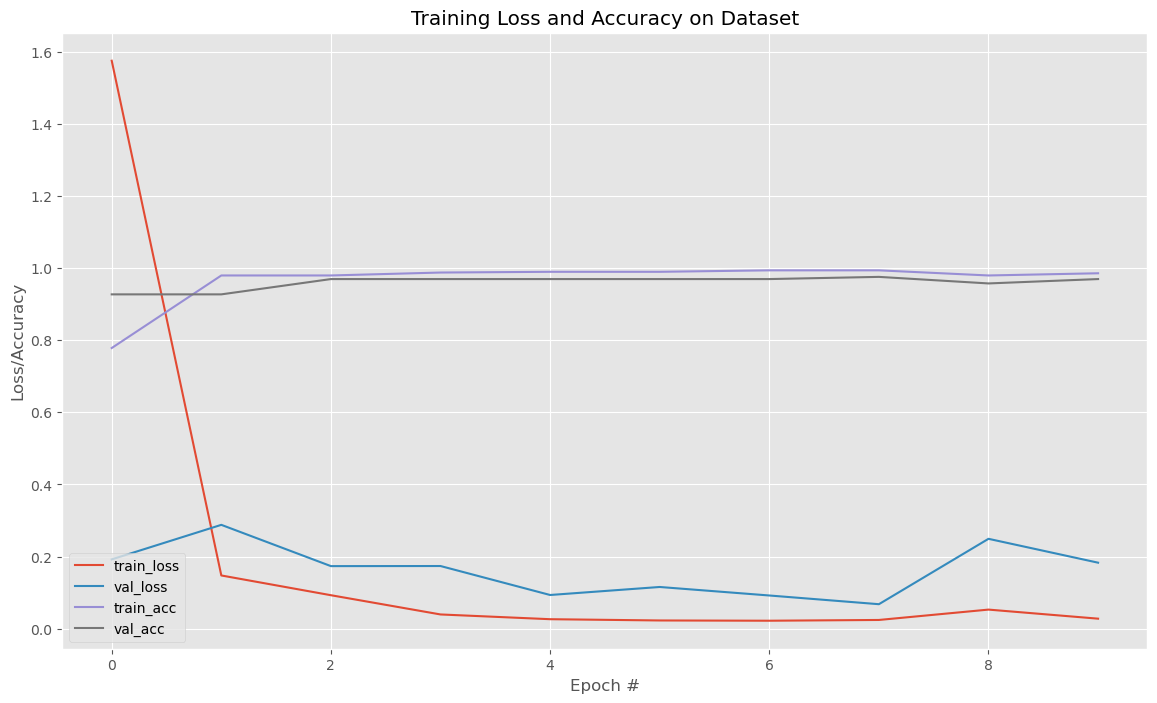

In [65]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) # softmax predictions need to be rounded 
y_pred = np.array(y_pred.tolist()) 

y_test = np.argmax(y_test, axis=1) 
y_test = np.array(y_test.tolist()) 
    
evaluate_model(H, y_pred, y_test)

# Exercise 2.1 - 4 classes

In [7]:
images, labels = load_images(['cloudy', 'sunrise', 'rain', 'shine'])

[INFO] Loading images...
Images shape: (1123, 150, 150, 3)
Labels shape: (1123,)
[INFO] Loaded 1123 images.


In [34]:
labels_onehot, mapped_categories = onehot_encode_2bit(labels, images)

[INFO] Performing one-hot encoding on multiple nodes...
Mapping between column indices and original classes:
{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}
Images shape: (1123, 150, 150, 3)
Labels encoded using OneHotEncoder(), labels.shape: (1123, 4)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels_onehot, test_size=0.25, random_state=12)

print(f'Shape of the training set: {X_train.shape}')
print(f'Shape of the test set: {X_test.shape}')

Shape of the training set: (842, 150, 150, 3)
Shape of the test set: (281, 150, 150, 3)


## Build a CNN Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

img_width, img_height, color_channel = X_train.shape[1:4]

classes = 4

# Build the CNN model
model = Sequential([
    # This layer extracts 64 different 3x3 features
    # Typically you’ll see strides of 2×2 as a replacement to max pooling:
    Conv2D(64, (3, 3), input_shape=(img_width, img_height, color_channel), padding="same", activation='relu'),
    Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation='relu'),
    Dropout(0.25), # Dropout helps generalize and not overfit. Neurons from the current layer, with probability p, will randomly disconnect from neurons in the next layer so that the network has to rely on the existing connections.

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    Dropout(0.25),

    Flatten(),
    # Use ReLU to avoid vanishing gradients problem
    Dense(512, activation='relu'),
    
    Dense(classes, activation='softmax'), # Binary Classification: One node per class, softmax activation.
])

model.summary()

2023-11-18 12:34:41.654048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 12:34:41.654088: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 12:34:41.654119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 12:34:41.666536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 12:34:42.261314: W tensorflow/compiler/

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 128)       147584    
                                                                 
 dropout_1 (Dropout)         (None, 38, 38, 128)       0         
                                                                 
 flatten (Flatten)           (None, 184832)            0

r/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 12:34:44.051722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 12:34:44.051781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 12:34:44.051786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1977] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-11-18 12:34:44.051853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to r

In [11]:
# Consider using 'binary_crossentropy' if you only have 2 classes.
# In other cases (more classes use 'categorical_crossentropy')
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

H = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test)) 

Epoch 1/10


2023-11-18 12:34:50.681045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-18 12:34:51.559251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-11-18 12:34:51.665159: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-18 12:34:52.213158: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-18 12:34:52.604873: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb1140affd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-18 12:34:52.604900: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute C

27/27 [==============================] - 6s 63ms/step - loss: 1.8517 - accuracy: 0.5297 - val_loss: 0.7207 - val_accuracy: 0.7295
Epoch 2/10
27/27 [==============================] - 1s 37ms/step - loss: 0.6474 - accuracy: 0.7850 - val_loss: 0.4951 - val_accuracy: 0.7972
Epoch 3/10
27/27 [==============================] - 1s 37ms/step - loss: 0.4602 - accuracy: 0.8207 - val_loss: 0.4321 - val_accuracy: 0.8505
Epoch 4/10
27/27 [==============================] - 1s 37ms/step - loss: 0.3703 - accuracy: 0.8492 - val_loss: 0.4059 - val_accuracy: 0.8399
Epoch 5/10
27/27 [==============================] - 1s 37ms/step - loss: 0.3237 - accuracy: 0.8682 - val_loss: 0.3454 - val_accuracy: 0.8897
Epoch 6/10
27/27 [==============================] - 1s 37ms/step - loss: 0.2817 - accuracy: 0.8979 - val_loss: 0.3681 - val_accuracy: 0.8719
Epoch 7/10
27/27 [==============================] - 1s 37ms/step - loss: 0.2857 - accuracy: 0.8979 - val_loss: 0.4961 - val_accuracy: 0.8185
Epoch 8/10
27/27 [======

9/9 [==============================] - 0s 44ms/step
[INFO] Evaluating model...
Type and shape of y_test: <class 'numpy.ndarray'> | (281,)
Type and shape of y_pred: <class 'numpy.ndarray'> | (281,)
Model's predictions:
[0 2 3 3 1 3 2 3 1 3 3 2 1 1 3 0 3 2 2 2 2 0 1 3 3 0 3 3 2 3 2 1 1 1 2 1 2
 3 2 1 3 2 1 3 3 3 3 2 1 1 3 3 2 3 1 1 0 0 0 3 3 3 1 1 3 1 1 2 0 0 2 3 3 2
 1 3 1 1 0 2 3 2 2 3 3 3 1 0 1 2 1 1 0 0 3 2 3 1 3 3 1 2 3 2 0 3 3 3 3 3 3
 3 3 2 3 3 2 0 2 1 2 3 2 0 1 3 0 2 0 2 2 3 2 3 1 0 1 3 0 1 2 1 2 1 2 0 2 0
 1 1 1 0 1 1 3 2 2 1 1 0 3 1 0 3 1 2 3 1 3 0 3 2 2 3 1 1 2 2 3 2 2 0 0 0 3
 0 2 3 1 1 3 0 2 3 2 3 1 3 3 1 1 0 3 3 2 0 2 1 3 3 2 3 3 2 1 3 3 2 1 2 1 2
 3 3 1 1 2 3 1 3 2 1 3 2 0 1 1 3 2 3 2 2 2 3 1 1 0 3 0 3 2 3 3 3 0 1 1 0 1
 1 1 1 2 2 2 2 3 1 3 0 2 3 0 3 1 3 3 3 3 3 0]

Confusion matrix:
[[38 22  6  0]
 [ 2 49  0  2]
 [ 1  1 64  2]
 [ 0  0  0 94]]
              precision    recall  f1-score   support

           0       0.93      0.58      0.71        66
           1       0.6

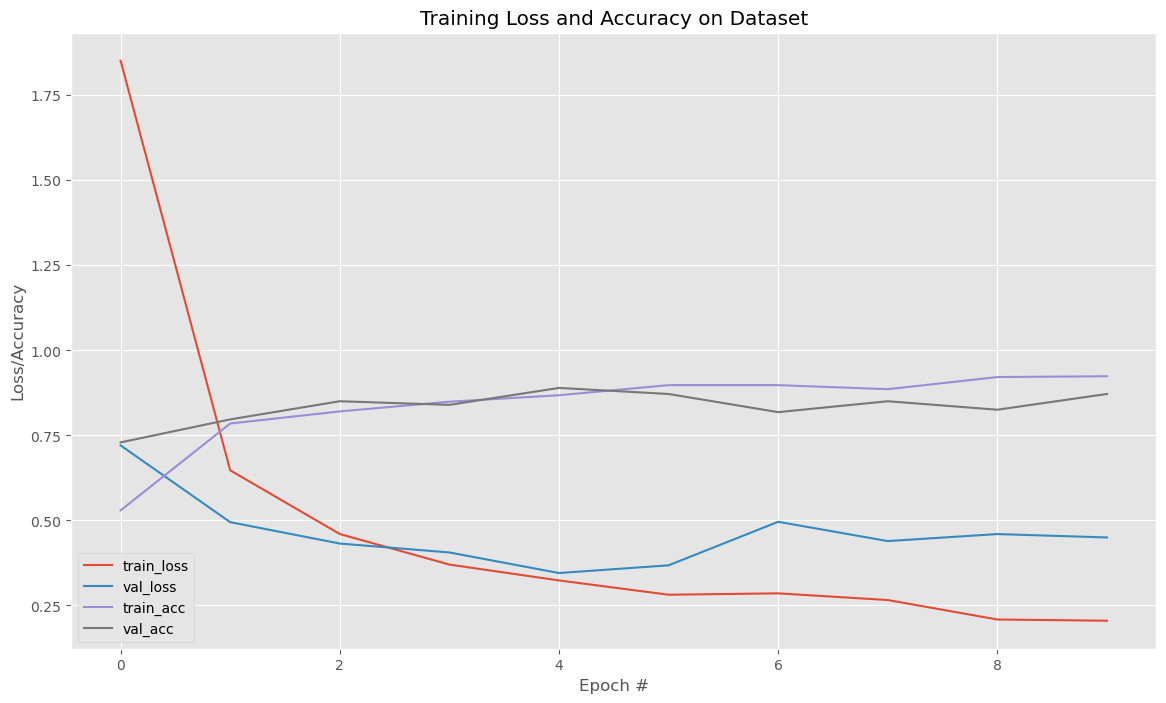

In [12]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) # softmax predictions need to be rounded 
y_pred = np.array(y_pred.tolist()) 

y_test = np.argmax(y_test, axis=1) 
y_test = np.array(y_test.tolist()) 
    
evaluate_model(H, y_pred, y_test)

## Manual tests

[INFO] Getting random images and predicting it's label.
1/1 [==============================] - 0s 13ms/step
[3 1 3 2]


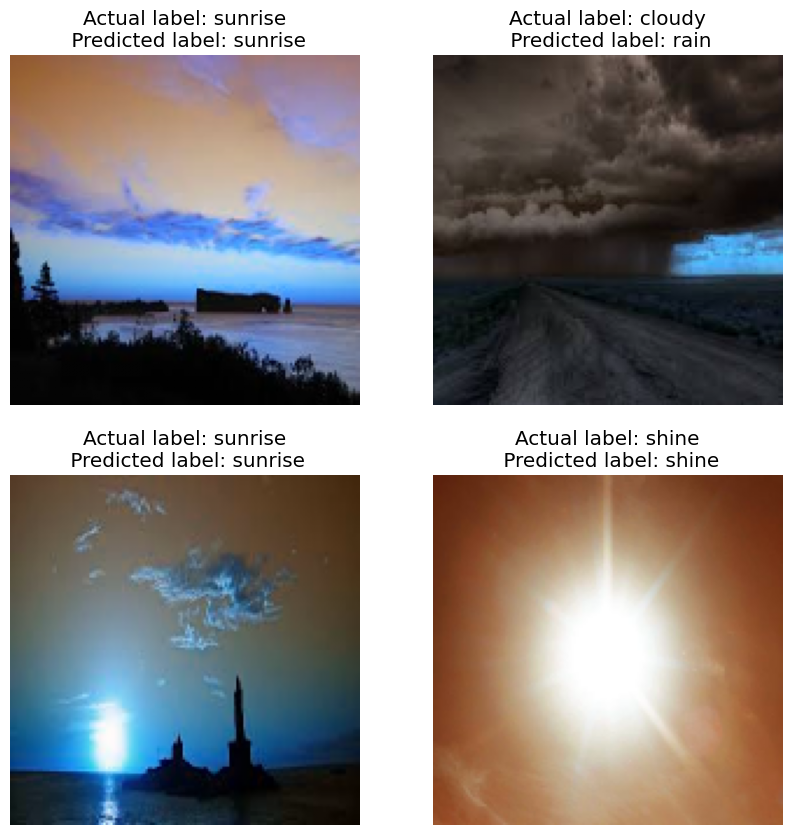

In [82]:
import random

print("[INFO] Getting random images and predicting it's label.")

randomlist = random.sample(range(0, len(X_test)), 4)

random_images = [X_test[i] for i in randomlist]
random_labels = [y_test[i] for i in randomlist]

random_images = np.array(random_images)
random_labels = np.array(random_labels)

predicted_labels = model.predict(random_images)
predicted_class_index = np.argmax(predicted_labels, axis=1)

print(predicted_class_index)

plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(random_images[i])
    plt.title(f'Actual label: {mapped_categories[random_labels[i]]}\n Predicted label: {mapped_categories[predicted_class_index[i]]}')
    plt.axis("off")

plt.show()